# Анализ тональности текста

Нужен инструмент, который будет искать токсичные комментарии. Необходимо обучить модель классифицировать комментарии на позитивные и негативные. В распоряжении набор данных с разметкой о токсичности правок.

F1 мера должна быть выше 0.75

### Описание данных

Столбец text содержит текст комментария, а toxic — целевой признак.

## Подготовка, Обучение, Выводы

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
import re
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
tqdm.pandas()

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
df = pd.read_csv('/datasets/toxic_comments.csv')
df

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159566,""":::::And for the second time of asking, when ...",0
159567,You should be ashamed of yourself \n\nThat is ...,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0
159569,And it looks like it was actually you who put ...,0


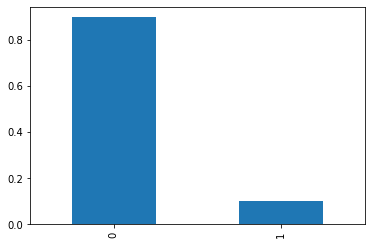

In [3]:
df['toxic'].value_counts(normalize = True).plot(kind = 'bar')

Наблюдается сильный дисбаланс классов.

In [4]:
corpus = df['text'].values.astype('U')

Функция лемматизации корпуса текстов.

In [5]:
def lemmatize(text):
    lemm_list = []
    lemmatizer = WordNetLemmatizer()
    for i in text:
        for j in i:
            lemm_list.append(lemmatizer.lemmatize(j))
    lemm_text = "".join(lemm_list)
    return lemm_text

функция очистки корпуса текстов от лишних символов.

In [6]:
def clear_text(text):
    pystoi = re.sub(r'[^a-zA-Z ]', ' ', text)
    return " ".join(pystoi.split())

In [7]:
df['text_lemm'] = ''
df['text_lemm'] = df.progress_apply(lambda x: lemmatize(clear_text(x['text'])), axis = 1)

100%|██████████| 159571/159571 [02:36<00:00, 1017.51it/s]


In [8]:
df

,text,toxic,text_lemm
0,Explanation\nWhy the edits made under my usern...,0,Explanation Why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,D aww He matches this background colour I m se...
2,"Hey man, I'm really not trying to edit war. It...",0,Hey man I m really not trying to edit war It s...
3,"""\nMore\nI can't make any real suggestions on ...",0,More I can t make any real suggestions on impr...
4,"You, sir, are my hero. Any chance you remember...",0,You sir are my hero Any chance you remember wh...
...,...,...,...
159566,""":::::And for the second time of asking, when ...",0,And for the second time of asking when your vi...
159567,You should be ashamed of yourself \n\nThat is ...,0,You should be ashamed of yourself That is a ho...
159568,"Spitzer \n\nUmm, theres no actual article for ...",0,Spitzer Umm theres no actual article for prost...
159569,And it looks like it was actually you who put ...,0,And it looks like it was actually you who put ...


In [9]:
stopwords = set(nltk_stopwords.words('english'))
count_td_idf = TfidfVectorizer(stop_words = stopwords)

In [10]:
target = df['toxic']
features = df['text_lemm']
features_train, features_test, target_train, target_test = train_test_split(features, target,
                                                                            test_size = 0.25,
                                                                            stratify = target,
                                                                            random_state = 42)

Разделение данных с учетом дисбаланса классов. (параметр stratify в train_test_split для равного распределения классов по выборкам)

In [11]:
features_train = count_td_idf.fit_transform(features_train)
features_test = count_td_idf.transform(features_test)

In [12]:
model = LogisticRegression(penalty='l1', C = 3, solver = 'saga')
model.fit(features_train, target_train)
preds = model.predict(features_test)
print('f1_logistic', f1_score(target_test, preds))

f1_logistic 0.7904544845153507


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


# Общий вывод

Первичной обработкой текстов было их очищение от лишних символов и лемматизация. Для этих целей были написаны 2 соответствующие функции.<br>
Далее была произведена оценка важности слов в корпусе на величиной TF-IDF, которая рассчитывалась с учетом выкидывания стоп-слов.<br>
После обучена модель с различными гиперпараметрами и общей настройкой весов классов. Затем модель была протестирована: лучший показатель метрики f1 оказался равным 0.7906166219839141<br>
Значительное улучшение значения метрики может быть достигнуто использованием моделей, основанных на нейронных сетях, либо возможно небольшое улучшение метрики с помощью тонкой настройки гиперпараметров классических моделей ML.<br>